In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [2]:
exchanges = {
    'binance':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USDT',
        },
    'coinbase':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            #'ripple':'xrp',
            'dollar':'USD',
        }, 
    'ftx':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        }, 
    'bitmex':
        {
            'bitcoin':'XBT',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        },
    'kraken':
        {
            'bitcoin':'XBT',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        },
    }

## Loading the Data

This is the part where we load all of the order books from the relevant cryptocurrency and exchange. The six days will be concatenated into a single order book called "ob_fq".

The user can change the underlying asset and exchange in this section.

In [3]:
days = 6
date = datetime.datetime(2022, 2, 28)
dates = [(date + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(days)]

In [4]:
exch = 'binance'
asset = 'ethereum'


# concatenate all date over the 6 day period into single dataframe resampled by frequency
ob_fq = pd.DataFrame()
for date_str in dates:
    try:
        path = 'tardis_raw.nosync/'+exch+'/'+exch+'_book_snapshot_5_'+date_str+'_'+exchanges[exch][asset]+exchanges[exch]['dollar']+'.csv.gz'
        ob = pd.read_csv(path, compression='gzip')
    except Exception as e:
        print(e)
        path = 'tardis_raw.nosync/'+exch+'/'+exch+'_book_snapshot_5_'+date_str+'_'+exchanges[exch][asset]+'USDT'+'.csv.gz'
        ob = pd.read_csv(path, compression='gzip')
        pass
    ob.sort_values(by='timestamp')
    ob['datetime'] = pd.to_datetime(ob['timestamp'], unit='us')
    ob_fq=pd.concat([ob_fq, ob], ignore_index=True)

In [5]:
ob_fq['mid_price'] = (ob_fq['asks[0].price'] + ob_fq['bids[0].price'])/2

In [6]:
# time frequency in minutes
fq = 10
first_timestamp = ob_fq['datetime'].iloc[0]
bins = int((ob_fq['datetime'].iloc[-1] - ob_fq['datetime'].iloc[0])/pd.Timedelta(minutes=fq))+1
timestamps = [first_timestamp+pd.Timedelta(minutes=fq*i) for i in range(bins)]

In [7]:
ob_fq.iloc[:100,:].to_csv('first_100.csv')

## Finding the traded price and traded volume between each timestamp

1) The bid and ask price hasn't moved, there are 3 possibilities:
- There has been no trades 
- Part of the asks[0] amount has beed executed at asks[0] price
- Part of the bids[0] amount has beed executed at bids[0] price

2) The price has shifted upwards:
- There has been buying market orders with total volumes that exceed asks[0].amount
- We compute the VWAP from the executed ASK orders

3) The price has shifted downwards:
- There has been selling market orders with total volumes that exceed bids[0].amount
- We compute the VWAP from the executed BID orders

REMARK: there can be simultaneous buying and selling orders between two timestamps, in that scenario we compute the VWAP of the executed bids AND asks


DEPTH ISSUE: if it was a big buy order at market price, we might not have enough market depth to compute an accurate VWAP....

ORDER FLOW ISSUE: if some (or none) orders at x have been executed but new orders came in at x (which makes the difference (t-1) - (t) < 0)


In [8]:
import progressbar

bar = progressbar.ProgressBar(maxval=ob_fq.shape[0]).start()

big_orders = 0

last_traded_price = ob_fq['mid_price'].iloc[0]
t_price = [0]
t_vol = [0]
t_vol_abs = [0]
for i in range(1,ob_fq.shape[0]):
    bar.update(i)

    # we will store the executed price * executed amount in this variable
    weighted_traded_price = 0

    # we will store the executed volume ("+"" for trades at ask price and "-" for trades at bid price)
    traded_volume = 0

    # we will store the absolute executed volume in this variable
    traded_volume_abs = 0
    
    # no change in the bid ask prices
    if ob_fq['asks[0].price'].iloc[i-1] == ob_fq['asks[0].price'].iloc[i] and ob_fq['bids[0].price'].iloc[i-1] == ob_fq['bids[0].price'].iloc[i]:
        # No trade
        if ob_fq['asks[0].amount'].iloc[i-1] == ob_fq['asks[0].amount'].iloc[i] and ob_fq['bids[0].amount'].iloc[i-1] == ob_fq['bids[0].amount'].iloc[i]:
            traded_price = last_traded_price
        else:
            # Execution at ask price
            if ob_fq['asks[0].amount'].iloc[i-1] > ob_fq['asks[0].amount'].iloc[i]:
                vol = max(ob_fq['asks[0].amount'].iloc[i-1] - ob_fq['asks[0].amount'].iloc[i],0)
                weighted_traded_price = weighted_traded_price+ob_fq['asks[0].price'].iloc[i-1] * vol
                traded_volume = traded_volume+vol
                traded_volume_abs = traded_volume_abs+vol

            # Execution at bid price
            if ob_fq['bids[0].amount'].iloc[i-1] > ob_fq['bids[0].amount'].iloc[i]:
                vol = max(ob_fq['bids[0].amount'].iloc[i-1] - ob_fq['bids[0].amount'].iloc[i],0)
                weighted_traded_price = weighted_traded_price+ob_fq['bids[0].price'].iloc[i-1] * vol
                traded_volume = traded_volume - vol
                traded_volume_abs = traded_volume_abs + vol
    
    else:
        # buy market order has been passed
        if ob_fq['asks[0].price'].iloc[i-1] < ob_fq['asks[0].price'].iloc[i]:
            k = 0
            # We go through the asking prices from the previous period until we reach the new asking price 0 from the current period
            while k<5 and ob_fq['asks['+str(k)+'].price'].iloc[i-1] <= ob_fq['asks[0].price'].iloc[i]:
                # when we reach the new asking price, the executed amount is the difference between the previous amount and the new one
                if ob_fq['asks['+str(k)+'].price'].iloc[i-1] == ob_fq['asks[0].price'].iloc[i]:
                    # if new orders at that price, the volume might have increased instead of decreased
                    vol = max(ob_fq['asks['+str(k)+'].amount'].iloc[i-1] - ob_fq['asks[0].amount'].iloc[i],0)
                    weighted_traded_price = weighted_traded_price + ob_fq['asks['+str(k)+'].price'].iloc[i-1] * vol
                    traded_volume = traded_volume + vol 
                    traded_volume_abs = traded_volume_abs + vol 
                    break
                # Case where the new asking price is higher than asks[k].price, in which case we know that the amount has been executed in full
                else:
                    weighted_traded_price = weighted_traded_price + ob_fq['asks['+str(k)+'].price'].iloc[i-1] * ob_fq['asks['+str(k)+'].amount'].iloc[i-1]
                    traded_volume = traded_volume + ob_fq['asks['+str(k)+'].amount'].iloc[i-1]
                    traded_volume_abs = traded_volume_abs + ob_fq['asks['+str(k)+'].amount'].iloc[i-1]
                k+=1
            # If k==5 then it means that we do not have enough order book depth to know precisely the traded volume and price
            if k == 5:
                big_orders+=1
            
        # sell market order has been passed
        if ob_fq['bids[0].price'].iloc[i-1] > ob_fq['bids[0].price'].iloc[i]:
            k = 0
            # We go through the bid prices from the previous period until we reach the new bid price 0 from the current period
            while k<5 and ob_fq['bids['+str(k)+'].price'].iloc[i-1] >= ob_fq['bids[0].price'].iloc[i]:
                # when we reach the new bid price, the executed amount is the difference between the previous amount and the new one
                if ob_fq['bids['+str(k)+'].price'].iloc[i-1] == ob_fq['bids[0].price'].iloc[i]:
                    # if new orders at that price, the volume might have increased instead of decreased
                    vol = max(ob_fq['bids['+str(k)+'].amount'].iloc[i-1] - ob_fq['bids[0].amount'].iloc[i],0)
                    weighted_traded_price = weighted_traded_price + ob_fq['bids['+str(k)+'].price'].iloc[i-1] * vol
                    traded_volume = traded_volume - vol 
                    traded_volume_abs = traded_volume_abs + vol 
                    break
                # Case where the new bid price is lower than bids[k].price, in which case we know that the amount has been executed in full
                else:
                    weighted_traded_price = weighted_traded_price + ob_fq['bids['+str(k)+'].price'].iloc[i-1] * ob_fq['bids['+str(k)+'].amount'].iloc[i-1]
                    traded_volume = traded_volume - ob_fq['bids['+str(k)+'].amount'].iloc[i-1]
                    traded_volume_abs = traded_volume_abs + ob_fq['bids['+str(k)+'].amount'].iloc[i-1]
                k+=1
            if k == 5:
                big_orders+=1

    if traded_volume_abs == 0: # when prices shift because new orders come in and decrease the bid-ask spread but no trade
        traded_price = last_traded_price
    else:
        traded_price = weighted_traded_price/traded_volume_abs # VWAP
        
    last_traded_price = traded_price
    t_price.append(traded_price)
    t_vol.append(traded_volume)
    t_vol_abs.append(traded_volume_abs)

ob_fq['Traded_Price'] = t_price
ob_fq['Traded_Volume'] = t_vol
ob_fq['Traded_Volume_Abs'] = t_vol_abs

In [9]:
# Computing the cumulated observable volumes on each side
ob_fq['bid_vol'] = ob_fq['bids[0].amount']+ob_fq['bids[1].amount']+ob_fq['bids[2].amount']+ob_fq['bids[3].amount']+ob_fq['bids[4].amount']
ob_fq['ask_vol'] = ob_fq['asks[0].amount']+ob_fq['asks[1].amount']+ob_fq['asks[2].amount']+ob_fq['asks[3].amount']+ob_fq['asks[4].amount']
# Compute the difference between the volumes of each side
ob_fq['b_a_diff'] = ob_fq['bid_vol'] - ob_fq['ask_vol']

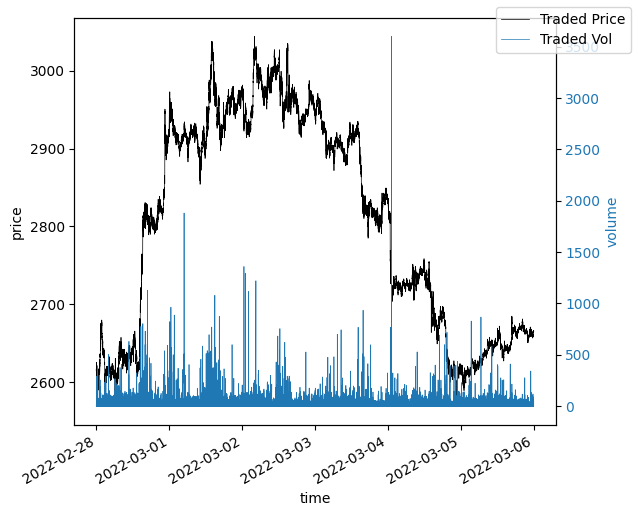

In [10]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('price', color='black')
ax1.plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Price'].iloc[1:], color='black',linewidth=0.5, label="Traded Price")
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Volume_Abs'].iloc[1:], color=color,linewidth=0.5, label="Traded Vol")
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(['Traded Price', 'Traded Vol'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [44]:
# priting the row for which there is a spike in volume to better understand
print(ob_fq[ob_fq['Traded_Volume_Abs']>3000])

        exchange   symbol         timestamp   local_timestamp  asks[0].price  \
2918498  binance  ETHUSDT  1646356153384000  1646356153465925         2710.0   

         asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
2918498       2313.0097        2709.99         56.3151        2710.18   

         asks[1].amount  ...  bids[4].amount                datetime  \
2918498          0.0065  ...          7.5938 2022-03-04 01:09:13.384   

         mid_price  Traded_Price  Traded_Volume  bid_vol   ask_vol  b_a_diff  \
2918498   2709.995        2710.0      3600.6506   67.786  2318.849 -2251.063   

                 P_V         VWAP  
2918498  9757763.126  2871.584378  

[1 rows x 33 columns]


In [45]:
# trying to see what happened between these two timestamps
print(ob_fq.iloc[2918497:2918499,:])

        exchange   symbol         timestamp   local_timestamp  asks[0].price  \
2918497  binance  ETHUSDT  1646356153284000  1646356153348043         2710.0   
2918498  binance  ETHUSDT  1646356153384000  1646356153465925         2710.0   

         asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
2918497       5913.6603        2709.99         15.7645        2710.18   
2918498       2313.0097        2709.99         56.3151        2710.18   

         asks[1].amount  ...  bids[4].amount                datetime  \
2918497          0.0065  ...        310.2628 2022-03-04 01:09:13.284   
2918498          0.0065  ...          7.5938 2022-03-04 01:09:13.384   

         mid_price  Traded_Price  Traded_Volume   bid_vol    ask_vol  \
2918497   2709.995   2718.273733       -30.5940  504.3025  5917.9379   
2918498   2709.995   2710.000000      3600.6506   67.7860  2318.8490   

          b_a_diff           P_V         VWAP  
2918497 -5413.6354  8.316287e+04  2871.695663  
2918498 -

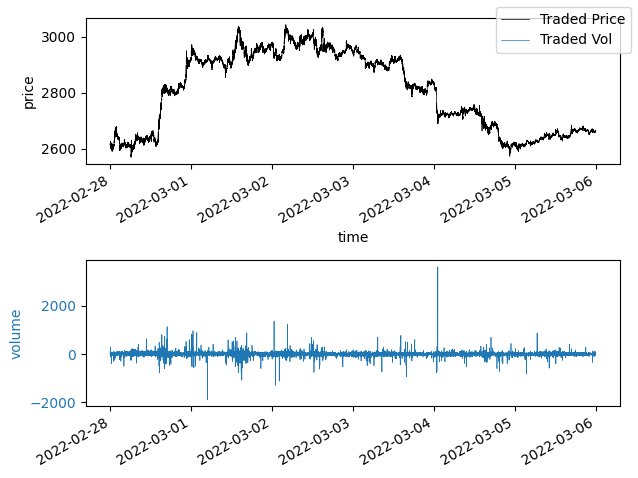

In [43]:
fig, axs = plt.subplots(2)


axs[0].set_xlabel('time')
axs[0].set_ylabel('price', color='black')
axs[0].plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Price'].iloc[1:], color='black',linewidth=0.5, label="Traded Price")
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
axs[0].tick_params(axis='y', labelcolor='black')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')

 # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
axs[1].set_ylabel('volume', color=color)  # we already handled the x-label with ax1
axs[1].plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Volume'].iloc[1:], color=color,linewidth=0.5, label="Traded Vol")
axs[1].tick_params(axis='y', labelcolor=color)
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

fig.legend(['Traded Price', 'Traded Vol'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

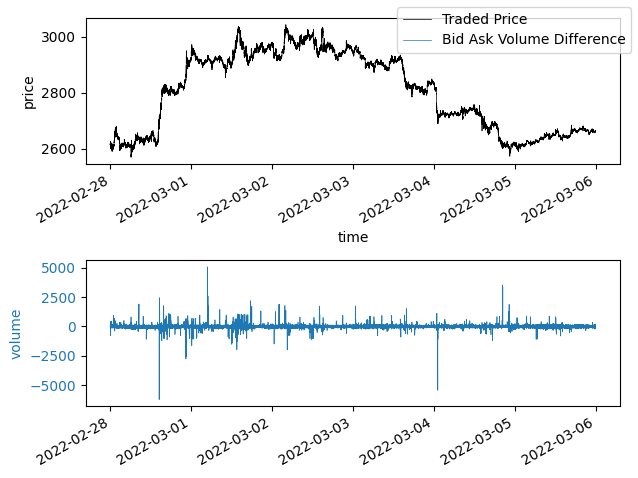

In [47]:
fig, axs = plt.subplots(2)


axs[0].set_xlabel('time')
axs[0].set_ylabel('price', color='black')
axs[0].plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Price'].iloc[1:], color='black',linewidth=0.5, label="Traded Price")
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
axs[0].tick_params(axis='y', labelcolor='black')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')

 # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
axs[1].set_ylabel('volume', color=color)  # we already handled the x-label with ax1
axs[1].plot(ob_fq['datetime'].iloc[1:],ob_fq['b_a_diff'].iloc[1:], color=color,linewidth=0.5, label="Traded Vol")
axs[1].tick_params(axis='y', labelcolor=color)
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

fig.legend(['Traded Price', 'Bid Ask Volume Difference'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [48]:
print(ob_fq[ob_fq['b_a_diff']<-5000])

        exchange   symbol         timestamp   local_timestamp  asks[0].price  \
438154   binance  ETHUSDT  1646058715860000  1646058715870628         2700.0   
438155   binance  ETHUSDT  1646058715960000  1646058715966294         2700.0   
438156   binance  ETHUSDT  1646058716060000  1646058716069289         2700.0   
2918497  binance  ETHUSDT  1646356153284000  1646356153348043         2710.0   

         asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
438154        6215.1702        2699.98         15.7205        2703.43   
438155        5425.2686        2699.99         20.9121        2701.59   
438156        5424.1288        2699.62          1.7900        2701.59   
2918497       5913.6603        2709.99         15.7645        2710.18   

         asks[1].amount  ...  bids[4].amount                datetime  \
438154           0.1294  ...          0.0503 2022-02-28 14:31:55.860   
438155           2.4499  ...          8.0688 2022-02-28 14:31:55.960   
438156           

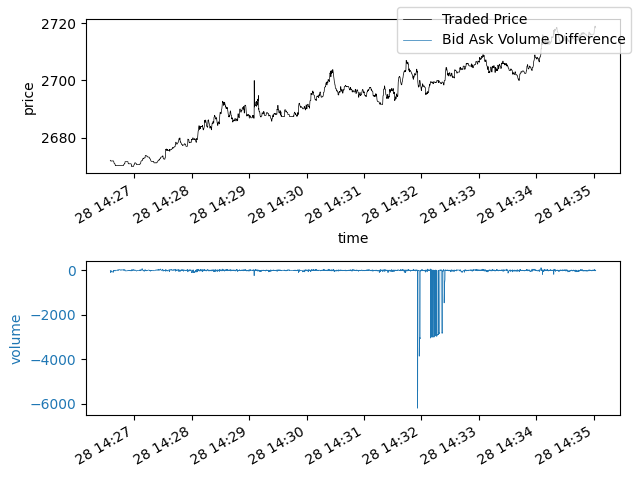

In [54]:
fig, axs = plt.subplots(2)


axs[0].set_xlabel('time')
axs[0].set_ylabel('price', color='black')
axs[0].plot(ob_fq['datetime'].iloc[435000:440000],ob_fq['Traded_Price'].iloc[435000:440000], color='black',linewidth=0.5, label="Traded Price")
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
axs[0].tick_params(axis='y', labelcolor='black')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')

 # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
axs[1].set_ylabel('volume', color=color)  # we already handled the x-label with ax1
axs[1].plot(ob_fq['datetime'].iloc[435000:440000],ob_fq['b_a_diff'].iloc[435000:440000], color=color,linewidth=0.5, label="Traded Vol")
axs[1].tick_params(axis='y', labelcolor=color)
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

fig.legend(['Traded Price', 'Bid Ask Volume Difference'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Computing VWAP

In [29]:
ob_fq['P_V'] = ob_fq['Traded_Price']*ob_fq['Traded_Volume'].abs()
ob_fq['VWAP'] = ob_fq['P_V'].cumsum()/ob_fq['Traded_Volume'].abs().cumsum()

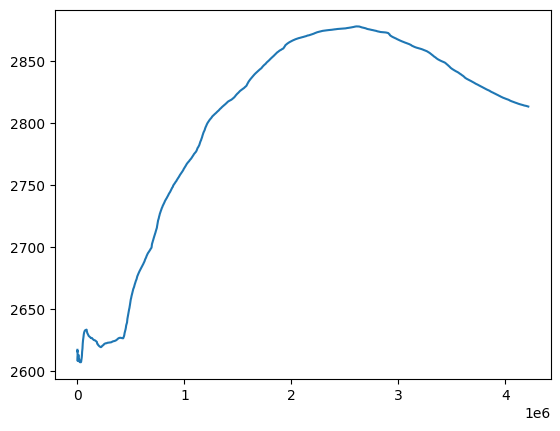

In [30]:
plt.plot(ob_fq['VWAP'].iloc[1:])
plt.show()

## Computing VWMA

In [31]:
def compute_vwma(p_v_copy, t_vol_copy, periods=500000) :
    # p_v_copy: array of cumulated Price * Volume
    # t_vol: array of comulated traded volumes
    # periods: time window of the moving averages
    p_v_copy[periods:] = p_v_copy[periods:] - p_v_copy[:-periods]
    t_vol_copy[periods:] = t_vol_copy[periods:] - t_vol_copy[:-periods]
    return p_v_copy[periods-1:]/t_vol_copy[periods-1:]


# def compute_ma(price_copy, periods=500000):
#     price_copy[periods:] = price_copy[periods:] - price_copy[:-periods]
#     return price_copy[periods-1:]/periods

# compute several cumulated sums that will be useful when computing the VWMAs
p_v = np.cumsum(np.array(ob_fq['P_V']))
t_vol = np.cumsum(np.array(ob_fq['Traded_Volume'].abs()))
price =np.cumsum(np.array(ob_fq['Traded_Price']))
b_a_vol_diff = np.cumsum(np.array(ob_fq['b_a_diff'].abs()))


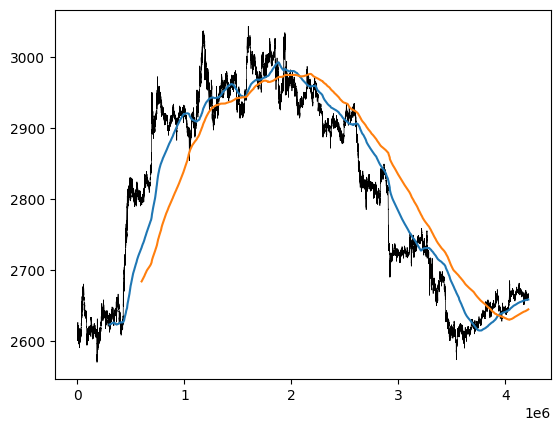

In [32]:
plt.plot(np.arange(ob_fq.shape[0]-1),ob_fq['Traded_Price'].iloc[1:], linewidth=0.5, color='black', label='Traded Price')
# plt.plot(ob_fq['VWAP'].iloc[1:])

for i in range(300000, 700000, 300000):
    vwma_v = compute_vwma(p_v.copy(),t_vol.copy(), i)
    plt.plot(np.arange(i-1, ob_fq.shape[0]),vwma_v, label='VWMA '+ str(int(i/1000))+'k')

# l = ['vwma_'+str(i) for i in range(100000, 2000000, 300000)]
# l.insert(0, 'Traded Price')

# fig.legend(l)
plt.legend()
plt.show()

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


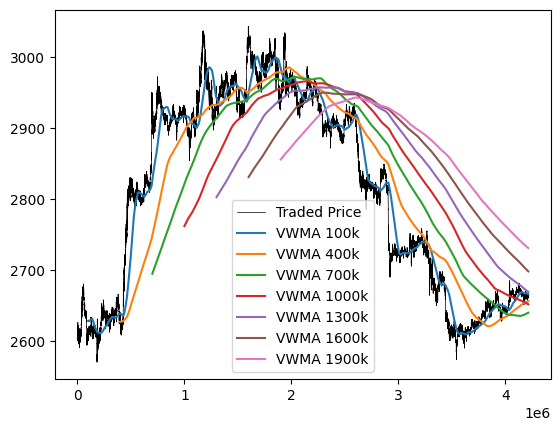

In [61]:
plt.plot(np.arange(ob_fq.shape[0]-1),ob_fq['Traded_Price'].iloc[1:], linewidth=0.5, color='black', label='Traded Price')

for i in range(100000, 2000000, 300000):
    ma_v = compute_vwma(price.copy(), i)
    plt.plot(np.arange(i-1, ob_fq.shape[0]),ma_v, label='VWMA '+ str(int(i/1000))+'k')

# l = ['ma_'+str(i) for i in range(100000, 2000000, 300000)]
# l.insert(0, 'Traded Price')

# fig.legend(['Traded Price', 'VWMA 100K', 'VWMA 400K', 'VWMA 700K', 'VWMA 1M', 'VWMA 1.3M', 'VWMA 1.6M', 'VWMA 1.9M'])
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()

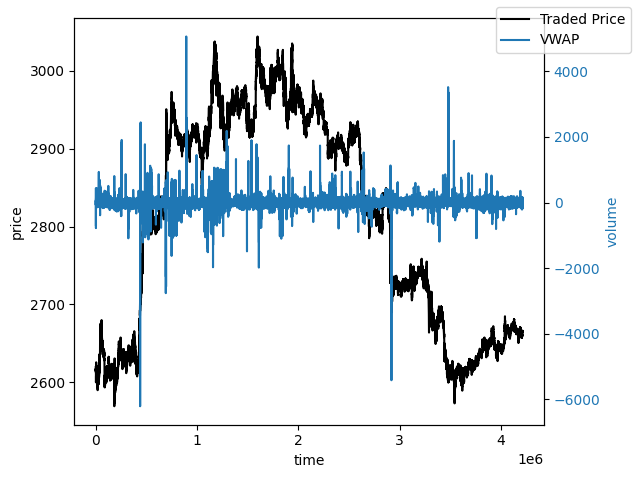

In [50]:
fig, axs = plt.subplots(2)


axs[0].set_xlabel('time')
axs[0].set_ylabel('price', color='black')
axs[0].plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Price'].iloc[1:], color='black',linewidth=0.5, label="Traded Price")
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
axs[0].tick_params(axis='y', labelcolor='black')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')

 # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
axs[1].set_ylabel('volume', color=color)  # we already handled the x-label with ax1
axs[1].plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Volume'].iloc[1:], color=color,linewidth=0.5, label="Traded Vol")
axs[1].tick_params(axis='y', labelcolor=color)
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

fig.legend(['Traded Price', 'Traded Vol'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()


fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('price', color='black')
ax1.plot(ob_fq['Traded_Price'].iloc[1:], color='black', label="Traded Price")
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(ob_fq['b_a_diff'].iloc[1:], color=color, label="Traded Vol")
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(['Traded Price', 'VWAP', 'Traded Vol'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

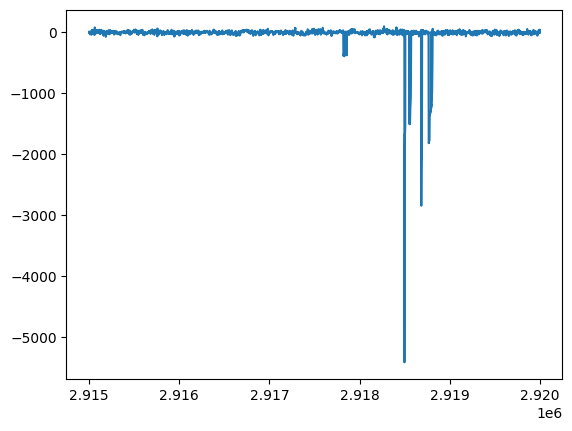

In [45]:
plt.plot(ob_fq['b_a_diff'].iloc[2915000:2920000])
plt.show()